# Data Science Fundamentals 5

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Science IT Support, University Of Bern, 2020

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Part 3.

In [0]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.mixture import GaussianMixture

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from matplotlib import  pyplot as plt
import numpy as np
import pandas as pd
from imageio import imread
from time import time as timer

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

from routines import *

# 1. Clustering

## 1. K-Means

### Theory overview.

**Objective:** clustering techniques divide the set of data into group of atoms having common features. Each data point $p$ gets assigned a label $l_p \in \{1,..,K\}$. In this presentation the data points are supposed to have $D$ features, i.e. each data point belongs to $\mathbf{R}^D$.

**Methods:** We call $P_k$ the subset of the data set which gets assigned to class $k$. K-means aims at minimizing the objective function:
$$L=\sum_k L_k$$
$$L_k=\frac{1}{|P_k|}\sum_{p,p' \in L_k}|\mathbf{x}_p-\mathbf{x}_{p'}|^2$$
One could enumerate all possibilities. The Llyod algorithm is iterative:  

- start with an initial guess of the assignements ;
- compute the centroid $\mathbf{c}_k$ for every cluster, defined as:
$$\mathbf{c}_k=\frac{1}{|P_k|}\sum_{p \in L_k} \mathbf{x_p}$$
- re-assign each data point to the class of the nearest centroid 
- re-compute the centroids and iterate till convergence

The Lloyd algorithm finds local minima and may need to be started several times with different initializations.

**Terminology and output of a K-means computation:**
- *Within-cluster variation* : $L_k$ is called within cluster variation. It can be shown that $L_k$ can be interpreted as the sum os squared variation with respect to the centroid 
- *Silhouette score*: K-means clustering fixes the number of clusters a priori. Some tecnhique must be chosen to score the different optimal clusterings for different $k$. One technique chooses the best *Silouhette score*  

### Sklearn: implementation and usage of K-means.

We start with a 2D example that can be visualized.

First we load the data-set.

In [0]:
points=km_load_th1()

Explore the data-set checking the dataset dimensionality.

In [0]:
print(points.shape)
print('We have ', points.shape[0], 'points with two features')

(120, 2)
We have  120 points with two features


Text(0, 0.5, 'feature-2')

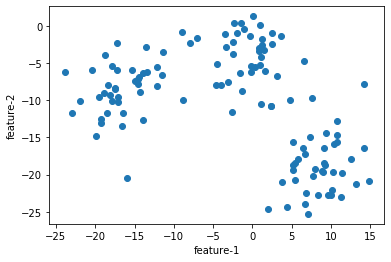

In [0]:
plt.plot(points[:,0],points[:,1],'o')
plt.xlabel('feature-1')
plt.ylabel('feature-2')

It looks visually that the data set has three clusters. We will cluster them using K-means. As usual, we create a KMeans object. Note that we do not need to initialize it with a data-set.

In [0]:
clusterer = KMeans(n_clusters=3, random_state=10)

A call to the fit method computes the cluster centers which can be plotted alongside the data-set. They are accessible from the cluster_centers_ attribute:

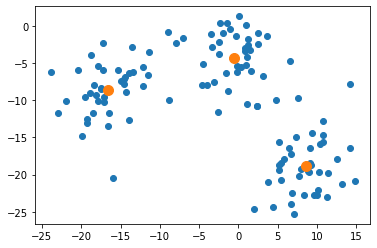

In [0]:
clusterer.fit(points)
plt.plot(points[:,0],points[:,1],'o')
plt.plot(clusterer.cluster_centers_[:,0],clusterer.cluster_centers_[:,1],'o',markersize=10)

The predict method assigns a new point to the nearest cluster. We can use predict with the training dataset and color the data-set according to the cluster label.

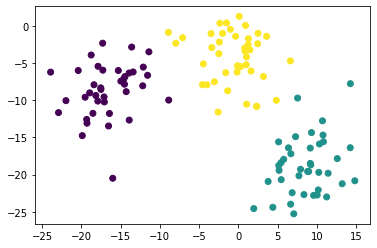

In [0]:
cluster_labels=clusterer.predict(points)
plt.scatter(points[:,0],points[:,1],c=cluster_labels)

Finally, we can try to vary the number of clusters and score them with the Silhouette score.

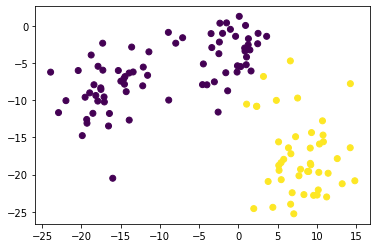

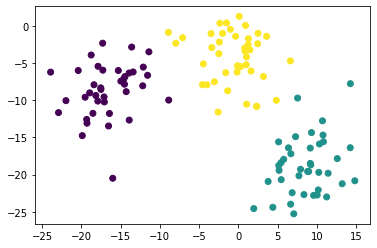

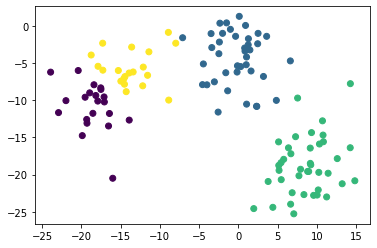

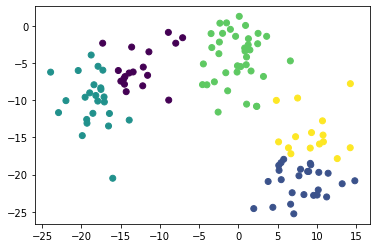

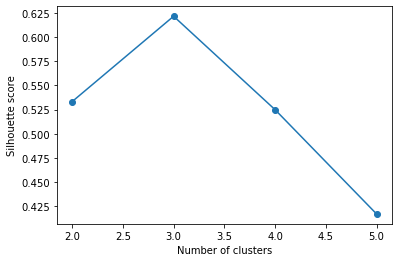

In [0]:
sil=[]

for iclust in range(2,6):
    clusterer = KMeans(n_clusters=iclust, random_state=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    sil.append(score)
    plt.figure()
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    
plt.figure()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.plot(np.arange(len(sil))+2, sil,'-o')


The same techniques can be used on high dimensional data-sets. We use here the famoust MNIST dataset for integer digits, that we are downloading from tensorflow.

In [0]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X=train_images[:5000,:].reshape(5000,-1)

(5000, 784)


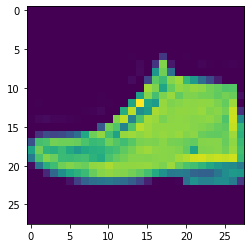

In [0]:
print(X.shape)
image=X[1232,:].reshape(28,28)
plt.imshow(image)

We can cluster the images exactly as we did for the 2d dataset.

In [0]:
clusterer = KMeans(n_clusters=10, random_state=10)
cluster_labels = clusterer.fit_predict(X)

We can plot the cluster centers (wich are 2D figures!) to see if the clustering is learning correct patterns! 

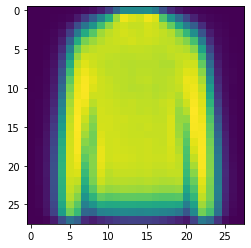

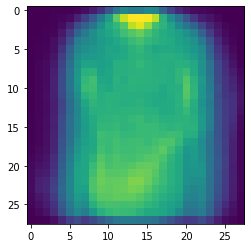

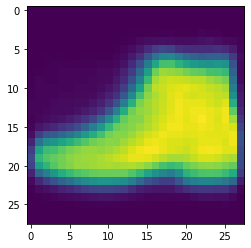

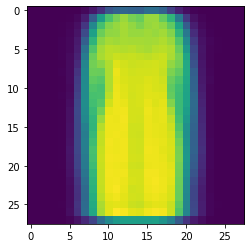

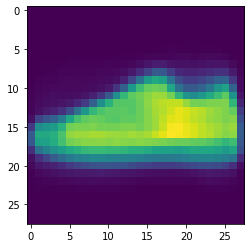

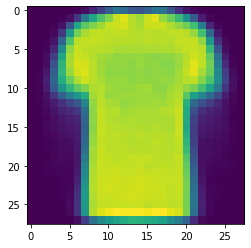

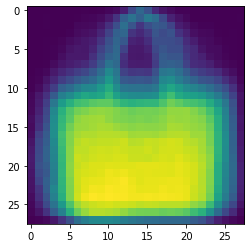

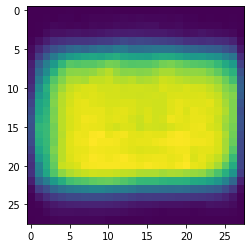

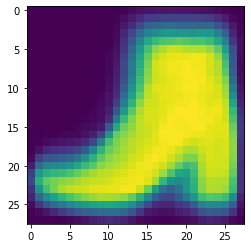

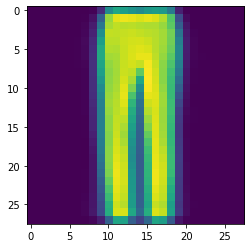

In [0]:
for iclust in range(10):
    plt.figure()
    plt.imshow(clusterer.cluster_centers_[iclust].reshape(28,28))

You can see that the model looks to assign one class to the same good. Nevertheless, using the cluster centers and with a further trick, in exercise 2 you will build a digit recognition model !

### EXERCISE 1: Discover the number of Gaussians

In [0]:
points=load_ex1_data_clust()

In this exercise you are given the dataset points, consisting of high-dimensional data. It was built taking random samples from a number k of multimensional gaussians. The data is therefore made of k clusters but, being very high dimensional, you cannot visualize it. Your task it too use K-means combined with the Silouhette score to find the number of k.

Number of clusters considered:  2
Number of clusters considered:  3
Number of clusters considered:  4
Number of clusters considered:  5
Number of clusters considered:  6
Number of clusters considered:  7
Number of clusters considered:  8
Number of clusters considered:  9
Number of clusters considered:  10
Number of clusters considered:  11
Number of clusters considered:  12
Number of clusters considered:  13
Number of clusters considered:  14


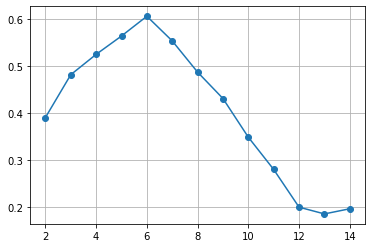

In [0]:
################### SOLUTION #####

scores=[]

for itrial in range(2,15):
    print('Number of clusters considered: ',itrial)
    clusterer = KMeans(n_clusters=itrial, random_state=10)
    cluster_labels = clusterer.fit_predict(points)
    score=silhouette_score(points,cluster_labels)
    scores.append(score)
    
plt.plot(np.arange(len(scores))+2,np.array(scores),'-o')
plt.grid()


### EXERCISE 2: Predict the good using K-Means

In this exercise you are asked to use the clustering performed by K-means to predict the good in the f-mnist dataset. Here we are using the clustering as a preprocessing for a supervised task. We need therefore the correct labels on a training set and to test the result on a test set:

In [0]:
fmnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fmnist.load_data()

X_train=train_images[:5000,:].reshape(5000,-1)
y_train=train_labels[:5000]

X_test=test_images[:1000,:].reshape(1000,-1)
y_test=test_labels[:1000]

**FITTING STEP**: The fitting step consists here in the computation of the cluster center, which was done during the presentation. To each cluster center we need to assign a label, which will be given by its majority class. You can use, if you want, the helper function most_common for this purpose:

In [0]:
# Helper function

def most_common(nclusters, supervised_labels, cluster_labels):
    
    """
    Args:
    - nclusters : the number of clusteres considered
    - supervised_labels : for each good, the labelling provided by the training data 
    - cluster_labels : for each good, the cluster it was assigned by K-Means
    
    Returns:
    - a list "assignement" of lengths nclusters, where assignement[i] is the majority class of the i-cluster 
    """
    
    assignement=[]
    for icluster in range(nclusters):
        indices=list(supervised_labels[cluster_labels==icluster])
        try:
            chosen= max(set(indices), key=indices.count)
        except ValueError :
            print('Em')
            chosen=1
        assignement.append(chosen)
    return assignement

################### SOLUTION #####

clusterer = KMeans(n_clusters=10, random_state=10)

clusterer.fit(X_train)

cluster_labels = clusterer.predict(X_train)
assignement=most_common(10, y_train, cluster_labels)     

print(assignement)

print('Training set')

cluster_labels = clusterer.predict(X_train)

new_labels=[assignement[i] for i in cluster_labels]

cm=metrics.confusion_matrix( y_train, new_labels)

print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
print(cm)

print()
print('Test set')

cluster_labels = clusterer.predict(X_test)
 
new_labels=[assignement[i] for i in cluster_labels]

cm=metrics.confusion_matrix( y_test, new_labels)

print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
print(cm)

[4, 6, 9, 3, 7, 0, 8, 8, 9, 1]
Training set
0.5492
[[248   6   0  62   6   0 131   1   3   0]
 [  1 482   0  37   8   0  28   0   0   0]
 [  5   0   0  14 324   0 153   1   7   0]
 [  7 165   0 223   5   0 101   0   0   0]
 [  2   2   0  77 333   0  68   0   6   0]
 [  0   0   0   0   0   0 111 291   2  89]
 [ 68   3   0  52 181   0 178   1   9   1]
 [  0   0   0   0   0   0   0 410   0 102]
 [  0   0   0   7  16   0  46  25 378  18]
 [  0   0   0   0   0   0  10   2   0 494]]

Test set
0.558
[[60  0  0 12  4  0 31  0  0  0]
 [ 0 94  0  6  0  0  5  0  0  0]
 [ 2  0  0  2 71  0 35  0  1  0]
 [ 2 25  0 48  1  0 17  0  0  0]
 [ 0  1  0 23 79  0 12  0  0  0]
 [ 0  0  0  0  0  0 17 55  0 15]
 [12  1  0  9 32  0 41  0  2  0]
 [ 0  0  0  0  0  0  0 78  0 17]
 [ 0  0  0  1  5  0 14  3 67  5]
 [ 0  0  0  0  0  0  1  3  0 91]]


So the model looks alreay good, even if we see that 5 and 9 are not assigned to any cluster. Can you improve it fitting more than 10 clusters ?

In [0]:
################### SOLUTION #####


for iclust in [10,20,30,40]:
    
        clusterer = KMeans(n_clusters=iclust, random_state=10)

        clusterer.fit(X_train)

        cluster_labels = clusterer.predict(X_train)
    
        assignement=most_common(iclust, y_train, cluster_labels)     

        print(assignement)
        
        print('Test set with '+str(iclust)+' clusters')

        cluster_labels = clusterer.predict(X_test)

        new_labels=[assignement[i] for i in cluster_labels]

        cm=metrics.confusion_matrix( y_test, new_labels)

        print(np.sum([cm[i,i] for i in range(cm.shape[0])])/np.sum(cm))
        print(cm)

[4, 6, 9, 3, 7, 0, 8, 8, 9, 1]
Test set with 10 clusters
0.558
[[60  0  0 12  4  0 31  0  0  0]
 [ 0 94  0  6  0  0  5  0  0  0]
 [ 2  0  0  2 71  0 35  0  1  0]
 [ 2 25  0 48  1  0 17  0  0  0]
 [ 0  1  0 23 79  0 12  0  0  0]
 [ 0  0  0  0  0  0 17 55  0 15]
 [12  1  0  9 32  0 41  0  2  0]
 [ 0  0  0  0  0  0  0 78  0 17]
 [ 0  0  0  1  5  0 14  3 67  5]
 [ 0  0  0  0  0  0  1  3  0 91]]
[2, 3, 5, 1, 0, 5, 1, 4, 2, 9, 2, 3, 9, 2, 8, 8, 9, 8, 7, 0]
Test set with 20 clusters
0.648
[[87  0  6 11  2  0  0  0  1  0]
 [ 5 93  1  6  0  0  0  0  0  0]
 [15  0 85  1 10  0  0  0  0  0]
 [18 16  3 55  1  0  0  0  0  0]
 [ 6  0 57 17 35  0  0  0  0  0]
 [ 0  0  0  0  0 73  0  4  0 10]
 [34  0 36  9 16  2  0  0  0  0]
 [ 0  0  0  0  0 14  0 59  0 22]
 [ 6  0  7  1  1  8  0  0 69  3]
 [ 0  0  0  0  0  3  0  0  0 92]]
[6, 0, 7, 3, 9, 1, 4, 9, 5, 4, 2, 8, 8, 1, 1, 9, 0, 2, 3, 4, 5, 7, 3, 8, 6, 5, 3, 9, 5, 2]
Test set with 30 clusters
0.652
[[69  0  3 22  4  3  6  0  0  0]
 [ 3 86  1 14  1  0  0  0 

## 2. Gaussian mixtures

### Theory overview.

K-Means is a modelling procedure which is biased towards clusters of circular shape and therefore does not always work perfectly, as the following examples show:

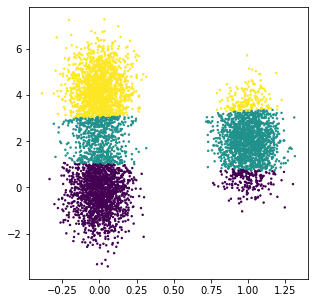

In [0]:
points=gm_load_th1()
clusterer = KMeans(n_clusters=3, random_state=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

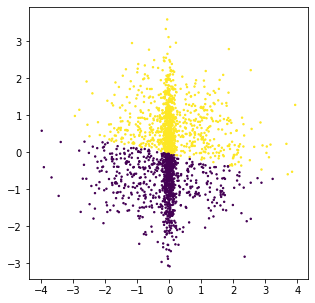

In [0]:
points=gm_load_th2()
clusterer = KMeans(n_clusters=2, random_state=10)
cluster_labels=clusterer.fit_predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

A Gaussian mixture model is able to fit these kinds of clusters. In a Gaussian mixture model each data-set is supposed to be a random point from the distribution:
$$f(\mathbf{x})=\sum_c \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x})$$
, which is called a Gaussian mixture. The parameters $\{\pi_c,\mathbf{\mu_c},\mathbf{\Sigma_c}\}$ are fitted from the data using a minimization procedure (maximum likelyhood via the EM algorithm) and $N_c$ is the chosen number of clusters.

**Output of a GM computation:** 
- *Cluster probabilities:* A gaussian mixtures model is an example of soft clustering, where each data point $p$ does not get assigned a unique cluser, but a distribution over clusters $f_p(c), c=1,...,N_c$. 

Given the fitted parameters,  $f_p(c)$ is computed as: $$f_p(c)=\frac{ \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x_p})}{\sum_c \pi_c N(\mathbf{\mu_c},\mathbf{\Sigma_c} )(\mathbf{x_p})}, c=1...N_c$$ 

- *AIC/BIC:* after each clustering two numbers are returned. These can be used to select the optimal number of Gaussians to be used, similar to the Silhouette score. ( AIC and BIC consider both the likelihood of the data given the parameters and the complexity of the model related to the number of Gaussians used ). The lowest AIC or BIC value is an indication of a good fit.

### Sklearn: implementation and usage of Gaussian mixtures

First of all we see how the Gaussian model behaves on our original example:

2 1592.1418091070063 1622.804218277609
3 1550.4974051432473 1597.884764770542
4 1553.5290520513042 1617.6413621352913
5 1560.815736563503 1641.6529971041823


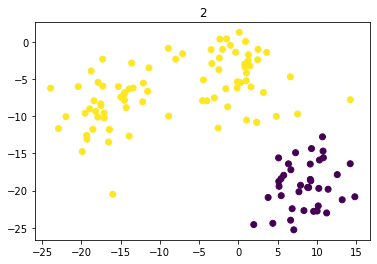

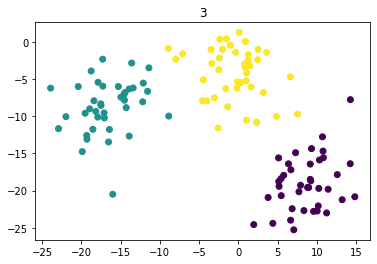

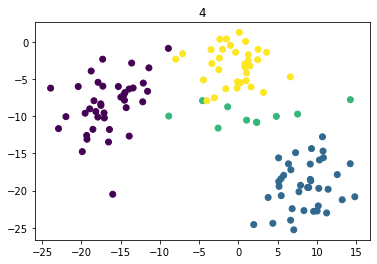

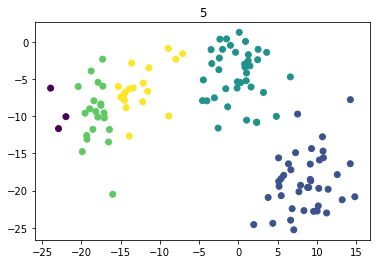

In [0]:
points=km_load_th1()

aic=[]
bic=[]
sil=[]

for i_comp in range(2,6):
    plt.figure()
    plt.title(str(i_comp))
    clf = GaussianMixture(n_components=i_comp, covariance_type='full')
    clf.fit(points)
    cluster_labels=clf.predict(points)
    plt.scatter(points[:,0],points[:,1],c=cluster_labels)
    print(i_comp,clf.aic(points),clf.bic(points))
    score=silhouette_score(points,cluster_labels)
    aic.append(clf.aic(points))
    bic.append(clf.bic(points))
    sil.append(score)

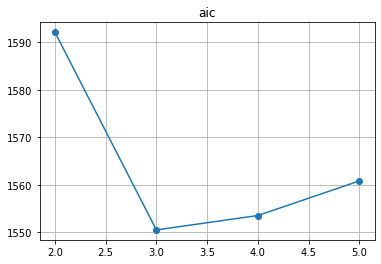

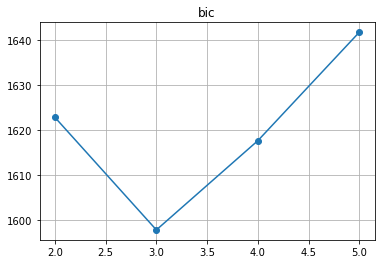

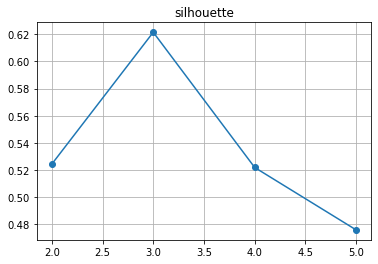

In [0]:
plt.plot(np.arange(2,6),aic,'-o')
plt.title('aic')
plt.grid()
plt.figure()
plt.plot(np.arange(2,6),bic,'-o')
plt.title('bic')
plt.grid()
plt.figure()
plt.plot(np.arange(2,6),sil,'-o')
plt.title('silhouette')
plt.grid()

So in this case we get a comparable results, and also the probabilistic tools agree with the Silhouette score ! Let's see how the Gaussian mixtures behave in the examples where K-means was failing.

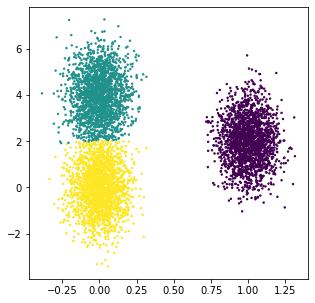

In [0]:
points=gm_load_th1()
clf = GaussianMixture(n_components=3, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

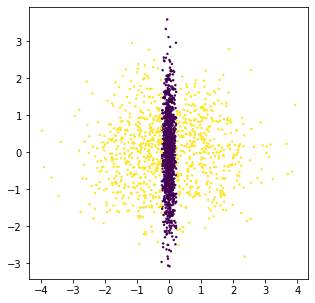

In [0]:
points=gm_load_th2()
clf = GaussianMixture(n_components=2, covariance_type='full')
clf.fit(points)
cluster_labels=clf.predict(points)
plt.figure(figsize=(5,5))
plt.scatter(points[:,0],points[:,1],c=cluster_labels, s=2)

### EXERCISE 3 : Find the prediction uncertainty

In this exercise you need to load the dataset used to present K-means ( def km_load_th1() ) . Applying a fitting based on gaussian mixtures you can not only predict the cluster label for each point, but also a probability distribution over the clusters. 

From this probability distribution, you can compute for each point the entropy of the corresponging distribution (using for example scipy.stats.entropy) as an estimation of the undertainty of the prediction. Your task is to plot the data-cloud with a color proportional to the uncertainty of the cluster assignement.

The commands:

##############

cm = plt.cm.get_cmap('RdYlBu')

plt.scatter(x, y, c=colors, cmap=cm)

plt.colorbar(sc)
##############

will plot the points (x,y) according to a list of predefined colors providing a color map.

Produce the same plots also for the other datasets shown in the theory part.

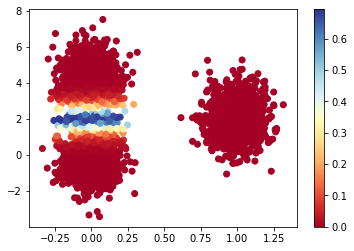

In [0]:
################### SOLUTION #####

from scipy.stats import entropy
points=gm_load_th1()

plt.figure()
clf = GaussianMixture(n_components=3, covariance_type='full')

clf.fit(points)
cluster_labels_prob=clf.predict_proba(points)

entropies=[]
for point in range(len(cluster_labels_prob)):
    entropies.append(entropy(cluster_labels_prob[point]))

cm = plt.cm.get_cmap('RdYlBu')
sc = plt.scatter(points[:,0], points[:,1], c=entropies, cmap=cm)
plt.colorbar(sc)
    

# 2. Neural Networks Introduction

## 1. Perceptron

(Artificial) Neural network consists of layers of neurons. Artificial neuron, or perceptron, is in fact inspired by a biological neuron.

<img src="https://scits-training.unibe.ch/data/figures/Perceptron.png" alt="drawing" width="30%"/>

Such neuron first calculates the linear transformation of the input vector $\bar x$: 
$$z = \bar W \cdot \bar x + b = \sum {W_i x_i} + b$$ where $\bar W$ is vector of weights and $b$ - bias.



## 2. Nonlinearity

Combining multiple of such objects performing linear transformation would not bring any additional benefit, as the combined output would still be a linear combination of the inputs.

What gives actual power to neurons, is that they additionally perform the nonlinear transformation of the result using activation function $f$ $$y = f(z)$$

The most commonly used non-linear transformations are:

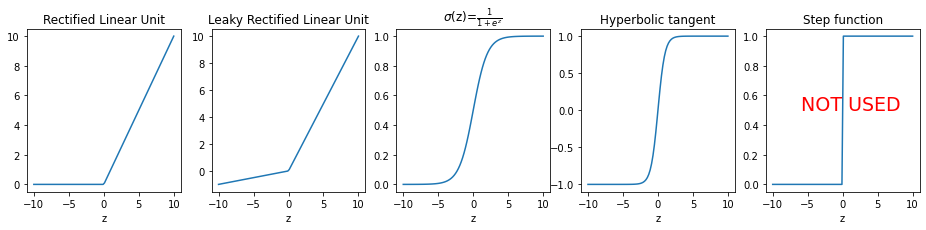

In [0]:
def ReLU(z):
  return np.clip(z, a_min=0, a_max=np.max(z))
def LReLU(z, a=0.1):
  return np.clip(z, a_min=0, a_max=np.max(z)) + np.clip(z, a_min=np.min(z), a_max=0) * a
def sigmoid(z):
  return 1/(1 + np.exp(-z)) 
def step(z):
  return np.heaviside(z, 0)
fig, ax = plt.subplots(1, 5, figsize=(16, 3))
z = np.linspace(-10, 10, 100)
ax[0].plot(z, ReLU(z))
ax[0].set_title('Rectified Linear Unit')
ax[1].plot(z, LReLU(z))
ax[1].set_title('Leaky Rectified Linear Unit')
ax[2].plot(z, sigmoid(z))
ax[2].set_title(r'$\sigma$(z)=$\frac{1}{1+e^z}$')
ax[3].plot(z, np.tanh(z))
ax[3].set_title('Hyperbolic tangent');
ax[4].plot(z, step(z)
)
ax[4].text(-6, 0.5, 'NOT USED', size=19, c='r')
ax[4].set_title('Step function');
for axi in ax:
  axi.set_xlabel('z')

And the reason we don't use a simple step function, is that it's not differentiable or it's derivative is zero everywhere.

The last nonlinearity to mention here is *softmax*:
$$y_i = Softmax(\bar z)_i = \frac{ e^{z_i}}{\sum_j e^{z_j}}$$

While each $z_i$ can hav any value, the corresponding $y_i\in[0,1]$, and $\sum_i y_i=1$, just like probabilities! 

While these $y_i$ are only pseudo-probabilities, this nonlinearity allowes one to model probabilities, e.g. of a data-point belonging to a certain class.






## 3. Fully connected net

In a fully connected neural network each layer is a set of N neurons, performing different transformations of all the same layer's inputs $\bar x = [x_i]$ producing output vector $\bar y = [y_j]_{i=1..N}$: $$y_j = f(\bar W_j \cdot \bar x + b_j)$$

Since output of each layer forms input of next layer, one can write for layer $l$: $$x^l_j = f(\bar W^l_j \cdot \bar x^{l-1} + b^l_j)$$ where $\bar x^0$ is network's input vactor.

<img src="https://scits-training.unibe.ch/data/figures/MLP.png" alt="drawing" width="50%"/>


## 4. Loss function

The last part of the puzzle is the measure of network performance, which is used to optimize the network's parameters $W^l_j$ and $b^l_j$.
Denoting the network's output for an input $x_i$ as $\hat y_i=\hat y_i(x_i)$ and given the label $y_i$:

1. In case of regression loss shows "distance" from target values:
* L2 (MSE): $L = \sum_i (y_i-\hat y_i)^2$
* L1 (MAE): $L = \sum_i |y_i-\hat y_i|$

1. In case of classification we can use cross-entropy, which shows "distance" from target distribution:
$$L = - \sum_i \sum_c y_{i,c} \log(\hat y_{i,c})$$
Here $\hat y_{i,c}$ - pseudo-probability of $x_i$ belinging to class $c$ and $y_{i,c}$ uses 1-hot encoding:

$$y_{i,c}= 
\begin{cases}
    1,& \text{if } x_i \text{ belongs to class } c\\
    0,              & \text{otherwise}
\end{cases}$$


# 3. Regression with neural network

Here we will build a neural network to fit an image.

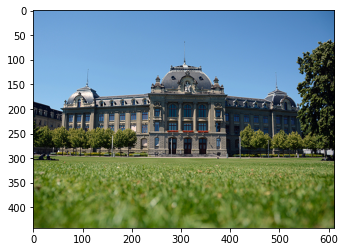

In [0]:
image_big = imread('https://www.unibe.ch/unibe/portal/content/carousel/showitem940548/UniBE_Coronavirus_612p_eng.jpg')
image_big = image_big[...,0:3]/255
plt.imshow(image_big)

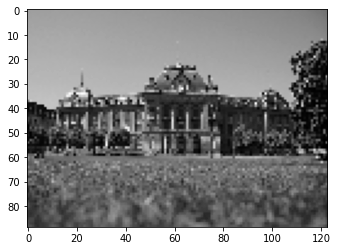

In [0]:
image = image_big[::5, ::5]
image = image.mean(axis=2, keepdims=True)
plt.imshow(image[...,0], cmap='gray')

In [0]:
h, w, c = image.shape

In [0]:
X = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((10947, 2), (10947, 1))

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [0]:
hist = model.fit(X, Y, epochs=500, batch_size=2048)

Epoch 1/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1560 - mse: 0.0386
Epoch 2/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1557 - mse: 0.0386
Epoch 3/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1554 - mse: 0.0386
Epoch 4/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1551 - mse: 0.0385
Epoch 5/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1549 - mse: 0.0385
Epoch 6/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1546 - mse: 0.0385
Epoch 7/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1543 - mse: 0.0384
Epoch 8/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1541 - mse: 0.0384
Epoch 9/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1539 - mse: 0.0383
Epoch 10/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1536 - mse: 0.0383
Epoch 11/500
6/6 [==============================] - 0s 2ms/step - loss: 0.1534 

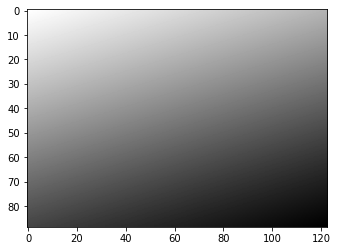

In [0]:
Y_p = model.predict(X)
Y_p = Y_p.reshape((h,w,c))
im = plt.imshow(Y_p[...,0], cmap='gray')

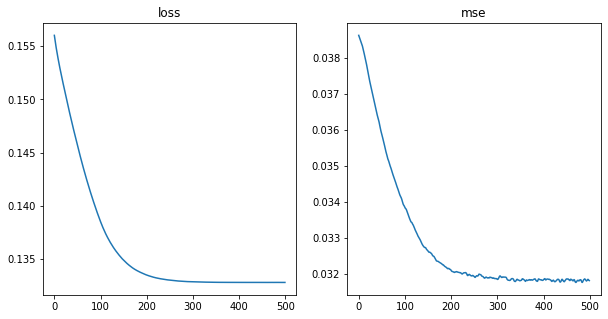

In [0]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
axs[0].plot(hist.epoch, hist.history['loss'])
axs[0].set_title('loss')
axs[1].plot(hist.epoch, hist.history['mse'])
axs[1].set_title('mse')
plt.show()

Let's try the same with an RGB image:

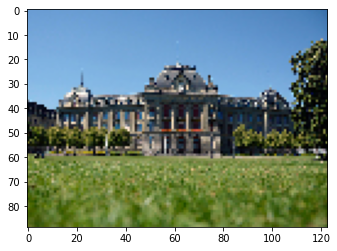

In [0]:
image = image_big[::5, ::5]
plt.imshow(image)

In [0]:
h, w, c = image.shape
X = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
X = np.stack(X, axis=-1).reshape((-1, 2))

Y = image.reshape((-1, c))
X.shape, Y.shape

((10947, 2), (10947, 3))

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 9         
Total params: 9
Trainable params: 9
Non-trainable params: 0
_________________________________________________________________


But now we will save images during the course of training, at first every 2 epochs, then every 20, every 200 and finally every 1000.
(**Remember**: call to `model.fit` does NOT reinitialize trainable variables. Every time it continues from the previous state):

In [0]:
ims = []
n_ep_tot = 0
for i in range(170):
  if i % 10 == 0:
    print(f'epoch {i}', end='\n')
  ne = (2 if (i<50) else (20 if (i<100) else (200 if (i<150) else 1000)))
  model.fit(X, Y, epochs=ne, batch_size=1*2048, verbose=0)

  Y_p = model.predict(X)
  Y_p = Y_p.reshape((h, w, c))
  ims.append(Y_p)
  n_ep_tot += ne

print(f'total numer of epochs trained:{n_ep_tot}')

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90
epoch 100
epoch 110
epoch 120
epoch 130
epoch 140
epoch 150
epoch 160
total numer of epochs trained:31100


In [0]:
%%capture
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

fig = plt.figure()
im = plt.imshow(ims[0])


def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [0]:
ani

While the colors properly represent the target image, out model still poses very limited capacity, allowing it to effectively represent only 3 boundaries.

Let's upscale out model:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(8, activation='relu'),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_32 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 1032      
_________________________________________________________________
dense_34 (Dense)             (None, 3)                 27        
Total params: 1,443
Trainable params: 1,443
Non-trainable params: 0
_________________________________________________________________


In [0]:
ims = []
n_ep_tot = 0
for i in range(180):
  if i % 10 == 0:
    print(f'epoch {i}', end='\n')
  ne = (2 if (i<50) else (20 if (i<100) else (200 if (i<150) else 1000)))
  model.fit(X, Y, epochs=ne, batch_size=1*2048, verbose=0)

  Y_p = model.predict(X)
  Y_p = Y_p.reshape((h, w, c))
  ims.append(Y_p)
  n_ep_tot += ne

print(f'total numer of epochs trained:{n_ep_tot}')

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90
epoch 100
epoch 110
epoch 120
epoch 130
epoch 140
epoch 150
epoch 160
epoch 170
total numer of epochs trained:41100


In [0]:
%%capture
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))

In [0]:
ani

## EXERCISE 4.

Load some image, downscale to a similar resolution, and train a deeper model, for example 5 layers, more parameters in widest layers.

Best:

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(2,)),
  tf.keras.layers.Dense(32, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU()),
  tf.keras.layers.Dense(c, activation='sigmoid'),
])
model.compile(optimizer='adam',
              loss='mae',
              metrics=['mse'])
model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 2)                 0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_42 (Dense)             (None, 512)               16896     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_44 (Dense)             (None, 16)                1040      
_________________________________________________________________
dense_45 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_46 (Dense)             (None, 3)               

In [0]:
ims = []
n_ep_tot = 0
for i in range(200):
  if i % 10 == 0:
    print(f'epoch {i}', end='\n')
  ne = (2 if (i<50) else (20 if (i<100) else (200 if (i<150) else 1000)))
  model.fit(X, Y, epochs=ne, batch_size=1*2048, verbose=0)

  Y_p = model.predict(X)
  Y_p = Y_p.reshape((h, w, c))
  ims.append(Y_p)
  n_ep_tot += ne

print(f'total numer of epochs trained:{n_ep_tot}')

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90
epoch 100
epoch 110
epoch 120
epoch 130
epoch 140
epoch 150
epoch 160
epoch 170
epoch 180
epoch 190
total numer of epochs trained:61100


In [0]:
%%capture
fig = plt.figure()
im = plt.imshow(ims[0])

def animate(i):
    img = ims[i]
    im.set_data(img)
    return im

ani = animation.FuncAnimation(fig, animate, frames=len(ims))